In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import seaborn as sns
from panco2 import PressureProfileFitter
from utils import gNFW
from chainconsumer import ChainConsumer

In [33]:
ppf = PressureProfileFitter(
    "../data/test_map_1.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
)

ppf.define_model("binned", np.arange(10, 1011, 100))
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.5 * P, 2.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
)

# Sample priors

In [34]:
prior_sample = pd.DataFrame(
    {k: p.rvs(10000) for k, p in ppf.model.priors.items()}
)

# MCMC

In [42]:
f = ppf.run_mcmc(30, 1e4, 6)

 10%|██████▌                                                           | 1003/10000 [00:47<07:06, 21.09it/s]

    1000 iterations


 20%|█████████████▏                                                    | 2001/10000 [01:35<06:25, 20.76it/s]

    2000 iterations


 30%|███████████████████▊                                              | 3002/10000 [02:24<05:33, 20.96it/s]

    3000 iterations


 40%|██████████████████████████▍                                       | 4004/10000 [03:12<04:43, 21.17it/s]

    4000 iterations


 50%|█████████████████████████████████                                 | 5002/10000 [04:00<03:55, 21.24it/s]

    5000 iterations


 60%|███████████████████████████████████████▌                          | 6003/10000 [04:48<03:11, 20.91it/s]

    6000 iterations


 70%|██████████████████████████████████████████████▏                   | 7004/10000 [05:37<02:28, 20.15it/s]

    7000 iterations


 80%|████████████████████████████████████████████████████▊             | 8003/10000 [06:25<01:35, 20.88it/s]

    8000 iterations


 90%|███████████████████████████████████████████████████████████▍      | 9004/10000 [07:13<00:46, 21.23it/s]

    9000 iterations


100%|█████████████████████████████████████████████████████████████████| 10000/10000 [08:01<00:00, 20.79it/s]


    10000 iterations


In [44]:
#f = np.load("./chains.npz")
yes = np.isfinite(f["lnprior"].flatten()) & np.isfinite(f["lnlike"].flatten())
yes2 = np.arange(0, len(yes), 10)
allchains = {k: f[k].flatten()[yes][yes2] for k in ppf.model.indices.keys()}

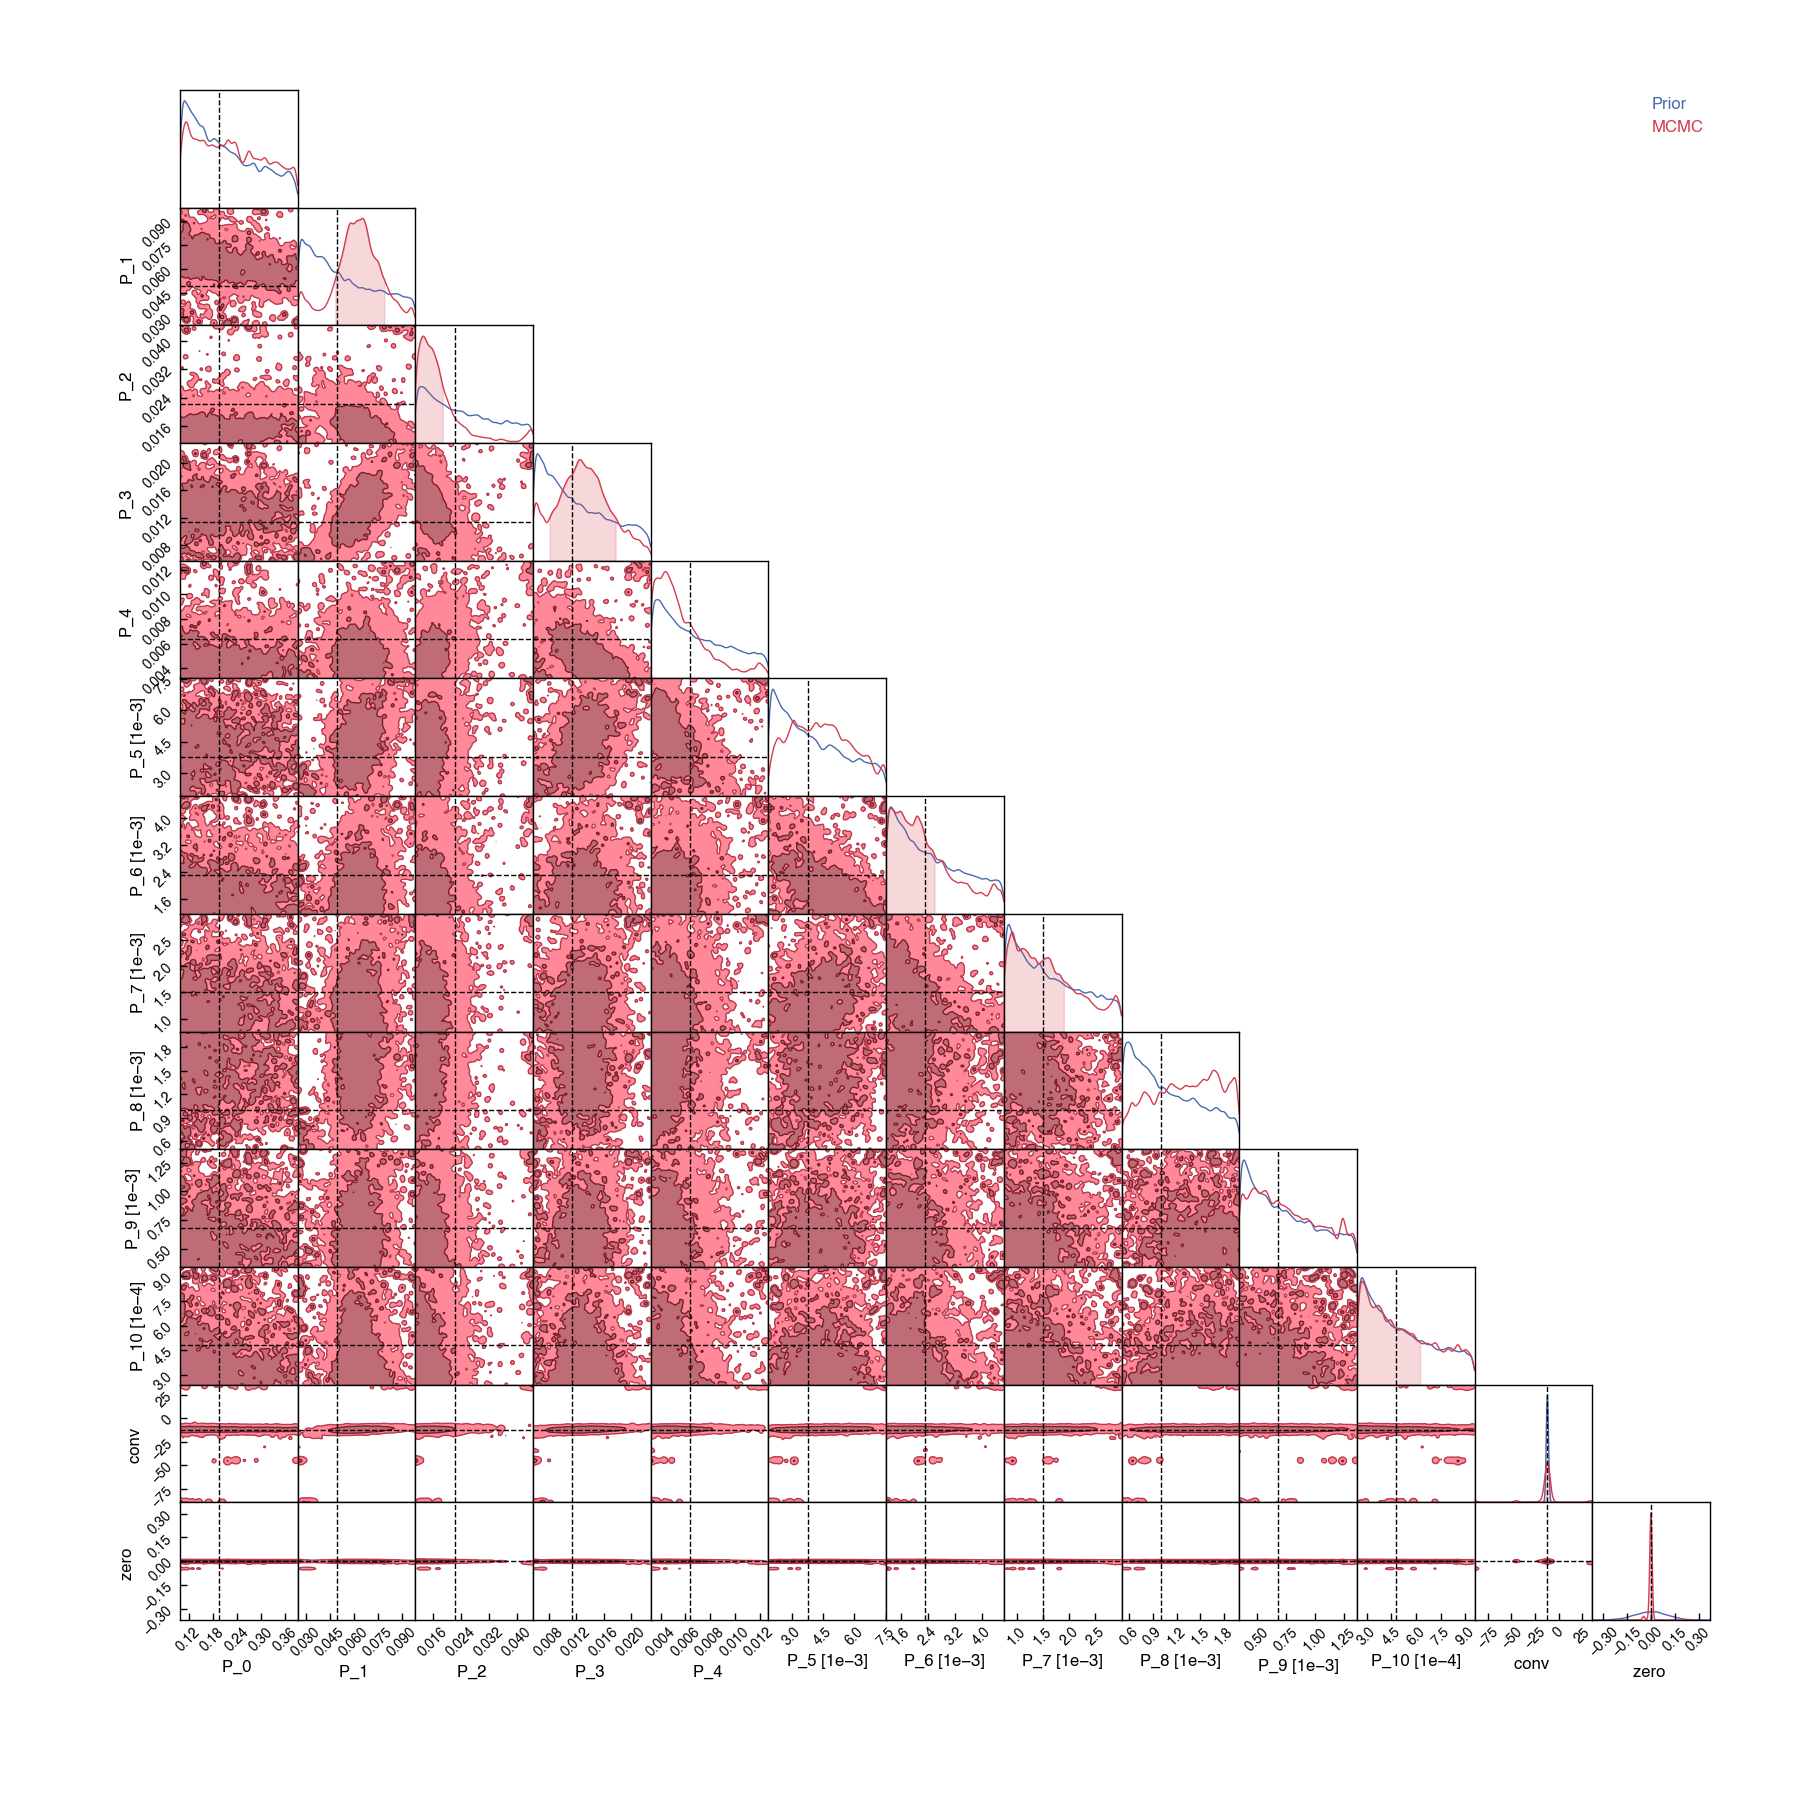

In [45]:
plt.close("all")
cc = ChainConsumer()
cc.add_chain(prior_sample, show_as_1d_prior=True, bar_shade=False, name="Prior")
cc.add_chain(allchains, name="MCMC")
cc.configure(cmap="Spectral_r", usetex=False, serif=False)
cf = cc.plotter.plot(truth=par_dic, figsize=(18, 18))